# Discovering the mechanism of methane clathrate formation

In this notebook we will apply the `aimmd` code to existing transition path sampling data of the formation of methane clathrates. The data has originally been generated for the publication "Unbiased atomistic insight in the competing nucleation mechanisms of methane hydrates." by Arjun, Berendsen and Bolhuis (PNAS  September 24 2019; 116(39):19305-19310) https://doi.org/10.1073/pnas.1906502116

The data was generated at four different temperatures T=270 K, T=275 K, T=280 K and T=285 K. Since for this system, the prevalent reaction mechanism changes with temperature, we will train on all temperatures combined and use the temperature as an additional input feature to see if the AI is able to find this change in mechanism.

We will first train a neural network to predict the commitment probabilities for the TPS data, check the accuracy of the prediction using the untrained committor data and then perform a relative input importance analysis to find the most relevant inputs which we will then use as inputs in a susequent symbolic regression run.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import aimmd

## load the data
We will first normalize the data to lie roughly in [0,1] and then directly put the data into two different `aimmd.Trainset`, one for training and one for validation.

In [4]:
f = np.load("methane_clathrate_TPS_training_data.npz")
# add temperature as last descriptor
descriptors_tps = [np.concatenate((f["descriptors_270K"], np.full((len(f["descriptors_270K"]), 1), 270)), axis=1),
                   np.concatenate((f["descriptors_275K"], np.full((len(f["descriptors_275K"]), 1), 275)), axis=1),
                   np.concatenate((f["descriptors_280K"], np.full((len(f["descriptors_280K"]), 1), 280)), axis=1),
                   np.concatenate((f["descriptors_285K"], np.full((len(f["descriptors_285K"]), 1), 285)), axis=1),
                   ]
descriptors_tps = np.concatenate(descriptors_tps, axis=0)

shot_results_tps = [f["shot_results_270K"],
                    f["shot_results_275K"],
                    f["shot_results_280K"],
                    f["shot_results_285K"],
                    ]
shot_results_tps = np.concatenate(shot_results_tps, axis=0)

# same for committors/validation data
f = np.load("methane_clathrate_committors_validation_data.npz")
# add temperature as last descriptor
descriptors_committors = [np.concatenate((f["descriptors_270K"], np.full((len(f["descriptors_270K"]), 1), 270)), axis=1),
                          np.concatenate((f["descriptors_275K"], np.full((len(f["descriptors_275K"]), 1), 275)), axis=1),
                          np.concatenate((f["descriptors_280K"], np.full((len(f["descriptors_280K"]), 1), 280)), axis=1),
                          np.concatenate((f["descriptors_285K"], np.full((len(f["descriptors_285K"]), 1), 285)), axis=1),
                          ]
descriptors_committors = np.concatenate(descriptors_committors, axis=0)

shot_results_committors = [f["shot_results_270K"],
                           f["shot_results_275K"],
                           f["shot_results_280K"],
                           f["shot_results_285K"],
                           ]
shot_results_committors = np.concatenate(shot_results_committors, axis=0)

# scale both to lie approximately in [0,1] accodrding to the TPS max/min values
descriptors_tps_scaled = (descriptors_tps - np.min(descriptors_tps, axis=0)) / (np.max(descriptors_tps, axis=0) - np.min(descriptors_tps, axis=0))
descriptors_committors_scaled = (descriptors_committors - np.min(descriptors_tps, axis=0)) / (np.max(descriptors_tps, axis=0) - np.min(descriptors_tps, axis=0))
# and put the data in the trainsets
trainset_tps = aimmd.TrainSet(2, descriptors=descriptors_tps_scaled, shot_results=shot_results_tps)
trainset_committors = aimmd.TrainSet(2, descriptors=descriptors_committors_scaled, shot_results=shot_results_committors)

In [5]:
len(trainset_tps)

3398

## Define a (simple) neural network and train it
We choose a comparably simple pyramidal architecture, because the descriptors are already a high level description of the system (i.e. collective variables designed by experts on the system) and because we have only around 3400 training points to train on.

In [6]:
import torch
import torch.nn.functional as F

In [7]:
n_base = trainset_tps.descriptors.shape[1]

ffnet = aimmd.pytorch.networks.FFNet(n_in=n_base,
                                     n_hidden=[int((n_base) / i) for i in range(1,9)],  # 8 hidden layer pyramidal network
                                     activation=F.elu,
                                     )

torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,
                                                 modules=[ffnet],
                                                 )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
# Note that this should be done after moving the model where it should live (e.g. 'cuda')
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

In [8]:
# open/create an aimmd.Storage for saving intermediate and final models
aimmd_store = aimmd.Storage('methane_clathrate_trainNN.h5', 'a')

In [9]:
model = aimmd.pytorch.EEScalePytorchRCModel(nnet=torch_model,
                                            optimizer=optimizer,
                                            states=["A", "B"],  # need to pass a list of states (with the correct length),
                                                                # such that the model know how many commitment probabilities it is supposed to predict
                                            loss=aimmd.pytorch.rcmodel.binomial_loss,  # if loss=None it will choose either binomial or multinomial loss,
                                                                                       # depending on the number of model outputs,
                                                                                       # but we could have also passed a custom loss function if we wanted to
                                            cache_file=aimmd_store,  # not strictly necessary if we do not do iterative training and density collection
                                            )

In [10]:
# split of test_frac (10%) of the training data as test data, which we will use to stop the training
test_frac = 0.1

val_split = np.zeros(len(trainset_tps), dtype=bool)
train_split = np.ones(len(trainset_tps), dtype=bool)
val_idxs = np.random.choice(np.arange(len(trainset_tps)), size=int(test_frac*len(trainset_tps)), replace=False)

val_split[val_idxs] = True
train_split[val_idxs] = False

# Note that aimmd.TrainSet can be sliced and will return a new aimmd.TrainSet containing only the slice data
trainset_train = trainset_tps[train_split]
trainset_val = trainset_tps[val_split]

In [11]:
# train the model
# stop if we reach either:
max_epochs = 100000  # maximum number of training epochs overall
max_epochs_sans_improvement = 10000  # maximum number of training epochs without a decrease in test loss

batch_size = None  # batch_size=None results in batches of the size of the trainset
#batch_size = 250

test_losses = []
test_losses.append(model.test_loss(trainset_val, batch_size=batch_size))
min_loss = test_losses[0]
train_losses = []
train = True
no_decrease = []
i = 0

while train and i <= max_epochs:
    train_losses.append(model.train_epoch(trainset_train, batch_size=batch_size))
    test_losses.append(model.test_loss(trainset_val, batch_size=batch_size))

    if test_losses[-1] <= min_loss:
        min_loss = test_losses[-1]
        no_decrease = []
        aimmd_store.rcmodels["best_model"] = model  # always store the model wit hthe best test loss
    else:
        no_decrease.append(1)
        if sum(no_decrease) >= max_epochs_sans_improvement:
            train = False

    i += 1

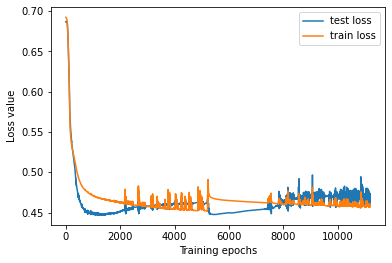

In [12]:
fig, axs = plt.subplots()

axs.plot(test_losses, label="test loss")
axs.plot(train_losses, label="train loss")

axs.set_ylabel("Loss value")
axs.set_xlabel("Training epochs")
axs.legend();

## Validation
Load the model with the best test loss and see how it performs on the untrained committor data. If everything went well all points in the the cross correlation plot should lie on the diagonal.

In [13]:
best_model = aimmd_store.rcmodels["best_model"]

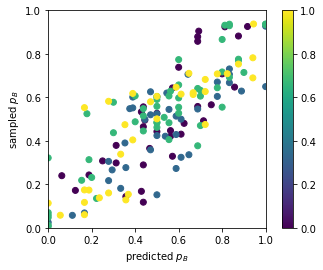

In [14]:
# NOTE: the colorcoding is for the temperature to spot if the models has trouble with a certain reaction mechanism/specific temperature
fig, axs = plt.subplots() 

p_B = trainset_committors.shot_results[:,1] / np.sum(trainset_committors.shot_results, axis=1)
p_B_hat = best_model(trainset_committors.descriptors)

ret = axs.scatter(p_B, p_B_hat, c=trainset_committors.descriptors[:, -1])
axs.set_aspect('equal')
axs.set_xlim(0,1)
axs.set_xlabel("predicted $p_B$")
axs.set_ylim(0,1)
axs.set_ylabel("sampled $p_B$")

plt.colorbar(ret);

## Relative input importance analysis
Here we will prepare a trainingset containing all points (committor and TPS data) to perform the relative input importance analysis with the best model. We use all data, because the model is already trained (i.e. no cross contamination possible) and we want the best/most reliable input importances to select the input coordinates to the symbolic regression.

In [15]:
trainset_all = aimmd.TrainSet(n_states=2,
                              descriptors=np.concatenate([trainset_tps.descriptors, trainset_committors.descriptors], axis=0),
                              shot_results=np.concatenate([trainset_tps.shot_results, trainset_committors.shot_results], axis=0)
                              )

In [16]:
hipr = aimmd.analysis.HIPRanalysis(best_model, trainset_all, n_redraw=100)

In [17]:
hipr_plus_mean, hipr_plus_std = hipr.do_hipr_plus()

Text(0.5, 0, 'coordinate index')

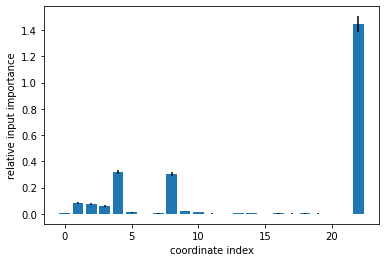

In [18]:
fig, axs = plt.subplots()

max_idxs = np.argsort(hipr_plus_mean[:-1])[::-1]

axs.bar(np.arange(trainset_all.descriptors.shape[1]), hipr_plus_mean[:-1] - hipr_plus_mean[-1], yerr=hipr_plus_std[:-1]);
axs.set_ylabel("relative input importance")
axs.set_xlabel("coordinate index")

In [19]:
print(max_idxs)

[22  4  8  1  2  3  9 10  5  0 14 13  7 18 16 11 19 17 15 12 21  6 20]


## Symbolic regression on the most relevant inputs

In [46]:
import pyaudi
import sympy as sp
from scipy.special import expit as sigmoid

### 3 most relevant inputs

In [78]:
n = 3  # how many of the most relevant coordinates to take
skip = 10  # take only every Nth step to speed up stuff a bit

# create training inputs for symbolic regression
# the training inputs need to be gdual_vdoubles, since we need to be able to calculate gradients w.r.t. them
xt = [pyaudi.gdual_vdouble(trainset_tps.descriptors[::skip, i]) for i in max_idxs[:n]]
# the targets can (and should for efficiency) also be numpy arrays, since we need no gradients for them
yt = trainset_tps.shot_results[::skip]

# always take all points for calculating the test loss
xtf = [pyaudi.gdual_vdouble(trainset_tps.descriptors[:, i]) for i in max_idxs[:n]]
ytf = trainset_tps.shot_results[:]

xt_val = [pyaudi.gdual_vdouble(trainset_committors.descriptors[:, i]) for i in max_idxs[:n]]
yt_val = trainset_committors.shot_results[:]

In [79]:
# initialize symbolic regression expression with random conectivity and random edge weights
expression = aimmd.symreg.initialize_random_expression(n,  # n inputs
                                                       1,  # 1 output: p_B
                                                       kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'], # potentially allowed elementary mathematical operations
                                                                                                            # our final expression will be a combination of those operations
                                                                                                            # could also add 'sin' and 'sig' for sine and sigmoid
                                                       )

# define/choose a loss function and a complexity regularization
lossFX = aimmd.symreg.losses.binom_loss  # binmial loss for models predicting p_B in a two state system
complex_fx = lambda ex: aimmd.symreg.losses.operation_count(ex, fact=0.0001)  # operation_count counts the number of elementary mathematical operations in the expression
complex_fx_reduced = lambda ex: aimmd.symreg.losses.operation_count(ex, fact=0.00001)  # and multiplies it with factor to get a loss contribution

In [80]:
# here we optimize the expression
lossL = []
loss_sans_regulL = []
val_lossL = []
genesL = []
weightsL = []
n_iter = 4  # do it n_iter times in a row to get a feeling for the stability of the result
for _ in range(n_iter):
    # initilize a new random expression every time, otherwise we would start the genetic algorithm from the previously optimized individual
    # (which would be the same as running one optimization n_iter times longer)
    expression = aimmd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'])
    loss, genes, weights = aimmd.symreg.optimize_expression(expression, # expression to optimize
                                                            4,  # number of mutants to create in every generation
                                                            300, # maximum number of generations
                                                            xt,  # training points
                                                            yt,  # training targets, i.e. shot results 
                                                            lossFX,  # either binomial loss for 2 state (predicting only p_B) or multinomial loss for N state
                                                            complexity_regularization=complex_fx,  # the combined lambda function(s) we use for complexity regularization
                                                                                                   # all of these do not need gradients w.r.t the weights
                                                            weight_regularization=None,  # combined lambda functions for weight regularizations
                                                                                         # these need and calculate the gradients w.r.t. edge weights
                                                            newtonParams={'steps':100},  # newton steps is what makes up most of the runtime,
                                                                                         # however if it is to small expressions will not converge in parameter space
                                                                                         # this can be diagnosed if we have many similar expression with different coeffs
                                                           )
    # store loss, genes and weights of the best expression found in every round
    lossL.append(loss)
    genesL.append(genes)
    weightsL.append(weights)
    # get the loss without regularization on the full dataset, i.e. the negative log-likeliehood (per shoting result)
    loss_sans_regulL.append(sum(lossFX(expression, xtf, ytf).constant_cf))
    # loss on validation data
    val_lossL.append(sum(lossFX(expression, xt_val, yt_val).constant_cf))

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [81]:
# print the resulting equations for every round
for vl, ll, l, g, w in zip(val_lossL, loss_sans_regulL, lossL, genesL, weightsL):
    # we take a dummy expression and set it to the optimal parameters we found previously
    expression.set(g)  # set genes to the best we found
    expression.set_weights(w)  # also set edge weights of the expression
    print('loss with regularization on training data: ', l)  # this is the loss we had in training, includes all regularizations and is calculated only over the reduced dataset
    print('losss without regularization on all data: ', ll)  # this is the loss of the expression on the full dataset without regularizations, i.e. log-likeliehood
    print("loss without regularization on validation data", vl)
    print(expression.simplify(['x{:d}'.format(idx) for idx in max_idxs[:n]], subs_weights=True))  # print the formula, subsitute edge weights to numbers
    print()

loss with regularization on training data:  0.4716814290249352
losss without regularization on all data:  0.4883249719184015
loss without regularization on validation data 0.6264201212994999
[30.2913301273025*x4 - 3.17070940997502*exp(1.63149762972136*x22 - 1.44526954954316*x8)]

loss with regularization on training data:  0.46497560578607905
losss without regularization on all data:  0.49220042430535693
loss without regularization on validation data 0.6348304459104475
[0.405630561484483*x22 + 27.9543575485224*x4 + 19.3369196873031*x8 - 3.24148924048479*exp(1.58865624870152*x22)]

loss with regularization on training data:  0.4648958727649503
losss without regularization on all data:  0.4910530163967353
loss without regularization on validation data 0.6339335853552982
[28.0955485291531*x4 + 18.9827767850314*x8 - 3.19960783650062*exp(1.57190519656104*x22)]

loss with regularization on training data:  0.4648958727649498
losss without regularization on all data:  0.4910530170398202
loss w

<ipython-input-82-57aa835c7ec5>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


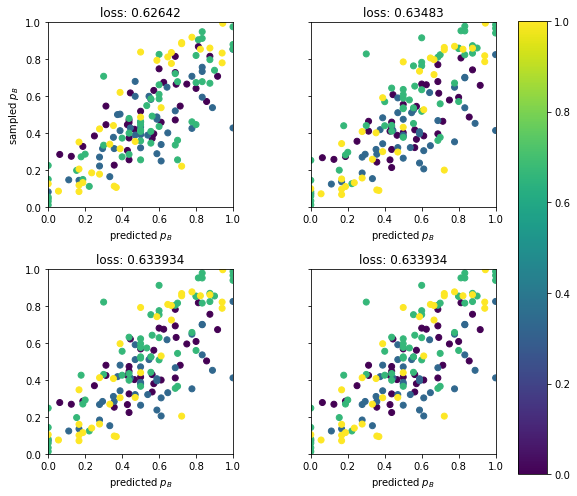

In [82]:
# plot the expression predictions on the validation data
fig, axs = plt.subplots(ncols=n_iter // 2, nrows=n_iter // 2, sharey=True, figsize=(8, 7))

for axnum, ax in enumerate(axs.flatten()):
    p_B = trainset_committors.shot_results[:,1] / np.sum(trainset_committors.shot_results, axis=1)
    
    # set genome and weights in expression
    expression.set(genesL[axnum])
    expression.set_weights(weightsL[axnum])
    # predict p_B
    q_B = expression([pyaudi.gdual_vdouble(trainset_committors.descriptors[:, i]) for i in max_idxs[:n]])[0].constant_cf
    p_B_hat = sigmoid(q_B)

    # plot it, again with color for the temperature
    ret = ax.scatter(p_B, p_B_hat, c=trainset_committors.descriptors[:, -1])    
    
    ax.set_title(f"loss: {round(val_lossL[axnum], 6)}")
    ax.set_aspect('equal')
    ax.set_xlim(0,1)
    ax.set_xlabel("predicted $p_B$")
    ax.set_ylim(0,1)
    if axnum == 0:
        ax.set_ylabel("sampled $p_B$")

cbar_ax = fig.add_axes([0.95, 0.05, 0.05, 0.9])
plt.colorbar(ret, cbar_ax);
fig.tight_layout()

### 5 most relevant inputs

In [83]:
n = 5  # how many of the most relevant coordinates to take
skip = 10  # take only every Nth step to speed up stuff a bit

# create training inputs for symbolic regression
# the training inputs need to be gdual_vdoubles, since we need to be able to calculate gradients w.r.t. them
xt = [pyaudi.gdual_vdouble(trainset_tps.descriptors[::skip, i]) for i in max_idxs[:n]]
# the targets can (and should for efficiency) also be numpy arrays, since we need no gradients for them
yt = trainset_tps.shot_results[::skip]

# always take all points for calculating the test loss
xtf = [pyaudi.gdual_vdouble(trainset_tps.descriptors[:, i]) for i in max_idxs[:n]]
ytf = trainset_tps.shot_results[:]

xt_val = [pyaudi.gdual_vdouble(trainset_committors.descriptors[:, i]) for i in max_idxs[:n]]
yt_val = trainset_committors.shot_results[:]

In [84]:
# initialize symbolic regression expression with random conectivity and random edge weights
expression_5in = aimmd.symreg.initialize_random_expression(n,  # n inputs
                                                           1,  # 1 output: p_B
                                                           kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'], # potentially allowed elementary mathematical operations
                                                                                                                # our final expression will be a combination of those operations
                                                                                                                # could also add 'sin' and 'sig' for sine and sigmoid
                                                           )

# define/choose a loss function and a complexity regularization
lossFX = aimmd.symreg.losses.binom_loss  # binmial loss for models predicting p_B in a two state system
complex_fx = lambda ex: aimmd.symreg.losses.operation_count(ex, fact=0.0001)  # operation_count counts the number of elementary mathematical operations in the expression
complex_fx_reduced = lambda ex: aimmd.symreg.losses.operation_count(ex, fact=0.00001)  # and multiplies it with factor to get a loss contribution

In [86]:
# here we optimize the expression
lossL_5in = []
loss_sans_regulL_5in = []
val_lossL_5in = []
genesL_5in = []
weightsL_5in = []
n_iter = 4  # do it n_iter times in a row to get a feeling for the stability of the result
for _ in range(n_iter):
    # initilize a new random expression every time, otherwise we would start the genetic algorithm from the previously optimized individual
    # (which would be the same as running one optimization n_iter times longer)
    expression_5in = aimmd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'])
    loss, genes, weights = aimmd.symreg.optimize_expression(expression_5in, # expression to optimize
                                                            4,  # number of mutants to create in every generation
                                                            300, # maximum number of generations
                                                            xt,  # training points
                                                            yt,  # training targets, i.e. shot results 
                                                            lossFX,  # either binomial loss for 2 state (predicting only p_B) or multinomial loss for N state
                                                            complexity_regularization=complex_fx,  # the combined lambda function(s) we use for complexity regularization
                                                                                                   # all of these do not need gradients w.r.t the weights
                                                            weight_regularization=None,  # combined lambda functions for weight regularizations
                                                                                         # these need and calculate the gradients w.r.t. edge weights
                                                            newtonParams={'steps':100},  # newton steps is what makes up most of the runtime,
                                                                                         # however if it is to small expressions will not converge in parameter space
                                                                                         # this can be diagnosed if we have many similar expression with different coeffs
                                                           )
    # store loss, genes and weights of the best expression found in every round
    lossL_5in.append(loss)
    genesL_5in.append(genes)
    weightsL_5in.append(weights)
    # get the loss without regularization on the full dataset, i.e. the negative log-likeliehood (per shoting result)
    loss_sans_regulL_5in.append(sum(lossFX(expression_5in, xtf, ytf).constant_cf))
    # loss on validation data
    val_lossL_5in.append(sum(lossFX(expression_5in, xt_val, yt_val).constant_cf))

In [87]:
# print the resulting equations for every round
for vl, ll, l, g, w in zip(val_lossL_5in, loss_sans_regulL_5in, lossL_5in, genesL_5in, weightsL_5in):
    # we take a dummy expression and set it to the optimal parameters we found previously
    expression_5in.set(g)  # set genes to the best we found
    expression_5in.set_weights(w)  # also set edge weights of the expression
    print('loss with regularization on training data: ', l)  # this is the loss we had in training, includes all regularizations and is calculated only over the reduced dataset
    print('losss without regularization on all data: ', ll)  # this is the loss of the expression on the full dataset without regularizations, i.e. log-likeliehood
    print("loss without regularization on validation data", vl)
    print(expression_5in.simplify(['x{:d}'.format(idx) for idx in max_idxs[:n]], subs_weights=True))  # print the formula, subsitute edge weights to numbers
    print()

loss with regularization on training data:  0.46869373764999606
losss without regularization on all data:  nan
loss without regularization on validation data 0.6363092247310607
[-12.1261927263328*x22 + 9.89369567042087*x8 + 7.06567011728873*log(x2) + 16.2302258835198]

loss with regularization on training data:  0.4710178591446967
losss without regularization on all data:  0.5068492911372328
loss without regularization on validation data 0.6350433507472742
[34.9687785792891*x2 - 3.88528394393582*exp(1.29749690075748*x22)]

loss with regularization on training data:  0.45255517894406116
losss without regularization on all data:  0.4862755278497238
loss without regularization on validation data 0.6221498825451286
[30.8560573376517*x2 + 14.9584792627143*x8 - 3.35646219423505*exp(1.58916796324242*x22)]

loss with regularization on training data:  0.45255517894406055
losss without regularization on all data:  0.48627552746914837
loss without regularization on validation data 0.6221498822526

<ipython-input-88-2753c5db9f99>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


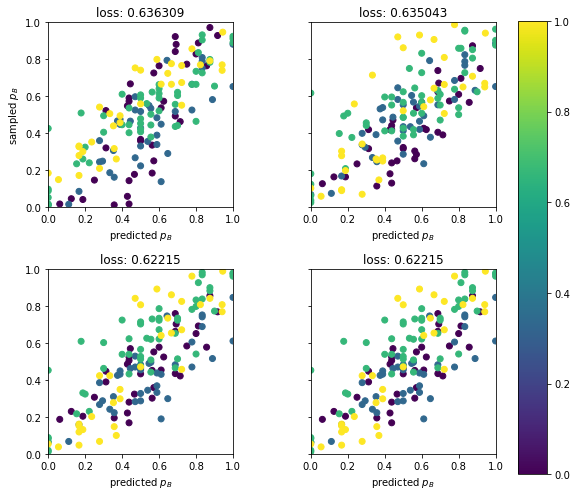

In [88]:
# plot the expression predictions on the validation data
fig, axs = plt.subplots(ncols=n_iter // 2, nrows=n_iter // 2, sharey=True, figsize=(8, 7))

for axnum, ax in enumerate(axs.flatten()):
    p_B = trainset_committors.shot_results[:,1] / np.sum(trainset_committors.shot_results, axis=1)
    
    # set genome and weights in expression
    expression_5in.set(genesL_5in[axnum])
    expression_5in.set_weights(weightsL_5in[axnum])
    # predict p_B
    q_B = expression_5in([pyaudi.gdual_vdouble(trainset_committors.descriptors[:, i]) for i in max_idxs[:n]])[0].constant_cf
    p_B_hat = sigmoid(q_B)

    # plot it, again with color for the temperature
    ret = ax.scatter(p_B, p_B_hat, c=trainset_committors.descriptors[:, -1])    
    
    ax.set_title(f"loss: {round(val_lossL_5in[axnum], 6)}")
    ax.set_aspect('equal')
    ax.set_xlim(0,1)
    ax.set_xlabel("predicted $p_B$")
    ax.set_ylim(0,1)
    if axnum == 0:
        ax.set_ylabel("sampled $p_B$")

cbar_ax = fig.add_axes([0.95, 0.05, 0.05, 0.9])
plt.colorbar(ret, cbar_ax);
fig.tight_layout()

In [89]:
aimmd_store.close()